In [1]:
import random
import numpy as np
import matplotlib
import numba
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

### NOTEBOOK 3
### Indhold: 
Oprindelige Prisoner's dilemma, en npc_player, en 2nd generation npc player der undercutter efter 3 Coop, og så går den tilbage så snart den bliver straffet \
PLUS hardcodet NPC 
Almindelig Q-learner, master Q-learner \
Intet master-theta eller epsilon ændring over generationer

In [2]:
#random.seed(1235)
#Demand function from Klein (2020)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(3,3), (0,5)],
            [(5,0), (1,1)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [3]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[t,:,p2]))
    return p3

In [4]:
@njit
def npc_player(options, q_table, epsilon, prev, time):
    if prev[time-1]==0 and prev[time]==0:
        npc_choice = 0
    else:
        npc_choice = 1
    return npc_choice

In [5]:
@njit
def npc_player_gen2(options, q_table, epsilon, prev_q, prev_npc, iq_counter, jnpc_counter):
    if prev_q[iq_counter-3] ==0 and prev_q[iq_counter-2]==0 and prev_q[iq_counter-1]==0:
        npc_choice = 1
        #print('Choices', prev_q, prev_npc, iq_counter, jnpc_counter)
    elif prev_q[iq_counter-4] ==0 and prev_q[iq_counter-3]==0 and prev_q[iq_counter-2]==0:
        #print(prev_npc[jnpc_counter-1])#int(prev_q[iq_counter-1])==0 and prev_npc[jnpc_counter-1]==1:
        
        npc_choice = 0
        #print('CASE')
    else:
        #print('tit4tat')
        npc_choice = int(prev_q[iq_counter-1])
    return npc_choice

In [25]:
# GRIM TRIGGER PLAYER
@njit
def npc_player_gen3(periods, prev_q, prev_npc, iq_counter, jnpc_counter):
    if jnpc_counter < int(periods/4):
        npc_choice = int(prev_q[iq_counter-1])
    else:
        if np.any(prev_q[int(periods/4):]== 1):
            npc_choice = 1
        else:
            npc_choice = 0

    return npc_choice

In [114]:
# Pavlov PLAYER
@njit
def npc_player_gen4(periods, prev_q, prev_npc, iq_counter, jnpc_counter):
    if jnpc_counter < int(periods/4):
        npc_choice = int(prev_q[iq_counter-1])
    elif prev_q[iq_counter-2]==0 and prev_q[iq_counter-1]==0:
        npc_choice = 0
    else:
        npc_choice = 1
    return npc_choice

In [115]:
# Tit for tat for two tats PLAYER
@njit
def npc_player_gen5(periods, prev_q, prev_npc, iq_counter, jnpc_counter):
    if jnpc_counter < int(periods/4):
        npc_choice = int(prev_q[iq_counter-1])
    elif prev_q[iq_counter-2]==1 and prev_q[iq_counter-1]==1:
        npc_choice = 1
    else: 
        npc_choice = 0
    return npc_choice

In [116]:
test = np.array([0,0,0,0,0,0,0])
print(test==1)
np.any(test[5:]==1)

[False False False False False False False]


np.False_

In [117]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
     if indic == 1: 
         p1 = prev[0,0]
         p2 = prev[1,0]
         p22 = prev[1,1]
         pe1 = Q[prev[0,0],prev[1,0]]
         ne1 = p1*PD_rewards(p1,p2)[0] + delta* p1*PD_rewards(p1,p22)[0] + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
         Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
         #print('GAME player 1 ne and pe', ne1, pe1)
     else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = p1*PD_rewards(p1,p2)[1] + delta* p1*PD_rewards(p1,p22)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [118]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, previous_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        
        # Current_t = numba.int64(np.floor(time/interval_size))
        # previous_t = numba.int64(np.floor((time-1)/interval_size))
                
        #print('indices',prev[0,0],prev[1,0],prev_time)
        #print('prices', my_old_price, their_new_choice, their_old_price)
        prev_q_est = Q[previous_t, prev[0,0],prev[1,0]]
        #print('PD_reward', PD_rewards(my_old_price,their_old_price))
        #print('argmax i Q', Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]])
        #print("PREV", prev[0,1])
        
        
        
        new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]]
        #print("New Q est", new_q_est)
        prev_interval = max(0,Current_t-1)
        next_interval = min(intervals-1, Current_t+1)
        
        #print("operation",(time/interval) - Current_t)
        #if (time/interval) - Current_t < 0.5:
        #        prev_w = 0.5 - abs((time/interval) - prev_interval )
        #        curr_w = 1-prev_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])
        #else:
        #        next_w = 0.5 - abs((time/interval) - next_interval) 
        #        curr_w = 1-next_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]])


        w_1 =  ( next_interval - time/interval) / (next_interval - prev_interval)
        w_2 =  (time/interval - prev_interval) / (next_interval-prev_interval) 
        #print('VÆGTE!!!:', w_1, w_2) 
        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (w_2 * new_q_est + w_1 * Q[next_interval, prev[0,0], prev[1,0]])
        #curr_w = 1-prev_w
        #Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]] + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])

In [188]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta, master_theta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    interval_size = periods/15
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (15,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            master_epsilon = (1-master_theta)**t
            if t % 2 != 0: 
                time_for_q = int(np.floor(t/interval_size))
                prev_time_for_q = int(np.floor((t-1)/interval_size))
                #print("TimeCHeck",time_for_q,time_for_q)
                #print('time for q', time_for_q, 'prev time for q', prev_time_for_q, "prev", prev_choices)
                update(q_table, prev_choices, alpha, delta, options, time_for_q, prev_time_for_q, t, interval_size)
                p_i =int(master_q_player(options, q_table, master_epsilon, prev_choices[1,1], time_for_q))

                #In Case of Q opponent:
                #regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 1)
                #p_i = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[1,1])
                
                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = int(options[p_i])
                i_counter += 1
                #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 
                #In Case of Q opponent:
                #regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 2)
                #p_j = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[0,1])
                #a hard coded opponent: 
                #p_j= npc_player(options, q_table, 0, all_choices1,j_counter)
                #p_j = int(npc_player_gen2(options, q_table, 0, all_choices1, all_choices2, j_counter, i_counter))
                #p_j = int(npc_player_gen3(periods, all_choices1, all_choices2,i_counter,j_counter))
                #p_j = int(npc_player_gen4(periods, all_choices1, all_choices2,i_counter,j_counter))
                p_j = int(npc_player_gen5(periods, all_choices1, all_choices2,i_counter,j_counter))

                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = int(options[p_j])
                j_counter += 1
                #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table





    
    

In [189]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    init_Q = init_q #np.zeros((10,2,2))
    for i in range(learners):
        print('run #',i+1 ,'of ', learners , 'runs')
        
        master_theta = theta*((i**2)/learners)
        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(init_Q, prices, periods, alpha, theta, delta, master_theta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        init_Q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_Q, all_choices1, all_choices2

In [190]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q, choices1, choices2 = many_games(options, 100000, 0.3, 0.0000922, 100 ,0.95, init_Q)
final_Q

run # 1 of  100 runs
run # 2 of  100 runs
run # 3 of  100 runs
run # 4 of  100 runs
run # 5 of  100 runs
run # 6 of  100 runs
run # 7 of  100 runs
run # 8 of  100 runs
run # 9 of  100 runs
run # 10 of  100 runs
run # 11 of  100 runs
run # 12 of  100 runs
run # 13 of  100 runs
run # 14 of  100 runs
run # 15 of  100 runs
run # 16 of  100 runs
run # 17 of  100 runs
run # 18 of  100 runs
run # 19 of  100 runs
run # 20 of  100 runs
run # 21 of  100 runs
run # 22 of  100 runs
run # 23 of  100 runs
run # 24 of  100 runs
run # 25 of  100 runs
run # 26 of  100 runs
run # 27 of  100 runs
run # 28 of  100 runs
run # 29 of  100 runs
run # 30 of  100 runs
run # 31 of  100 runs
run # 32 of  100 runs
run # 33 of  100 runs
run # 34 of  100 runs
run # 35 of  100 runs
run # 36 of  100 runs
run # 37 of  100 runs
run # 38 of  100 runs
run # 39 of  100 runs
run # 40 of  100 runs
run # 41 of  100 runs
run # 42 of  100 runs
run # 43 of  100 runs
run # 44 of  100 runs
run # 45 of  100 runs
run # 46 of  100 ru

array([[[60.        , 57.        ],
        [57.3925    , 53.39250002]],

       [[60.00000001, 57.00000001],
        [57.39250001, 53.39250536]],

       [[60.00000016, 57.00000048],
        [57.39250143, 53.3927921 ]],

       [[60.00000242, 57.00000768],
        [57.39252676, 53.39646838]],

       [[60.00003598, 57.0003517 ],
        [57.39381177, 53.41390592]],

       [[60.00114642, 57.01430678],
        [57.43091585, 53.46004878]],

       [[60.02114604, 57.22214419],
        [58.0882143 , 53.4657016 ]],

       [[60.42264596, 57.48891723],
        [61.69000142, 53.10401251]],

       [[60.3817804 , 57.43033365],
        [60.47729779, 46.58922058]],

       [[60.        , 56.9007891 ],
        [59.97363623,  0.        ]],

       [[60.        , 56.51047732],
        [59.71938709,  0.        ]],

       [[60.        , 55.37112885],
        [59.62690704,  0.        ]],

       [[60.        , 54.55629412],
        [58.93919677,  0.        ]],

       [[60.        , 52.05449736],
  

In [191]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [192]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

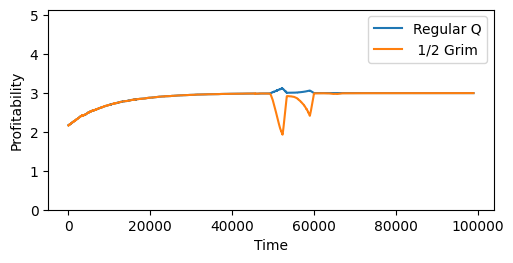

In [193]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='Regular Q')
plt.plot(t_arr2,profitability_arr2,'-', label=' 1/2 Grim')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0.00,5.15)
plt.legend()
plt.show()

In [194]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [195]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

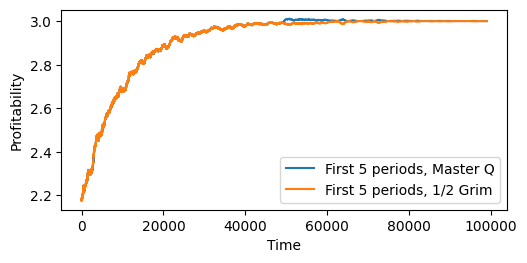

In [196]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, 1/2 Grim')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

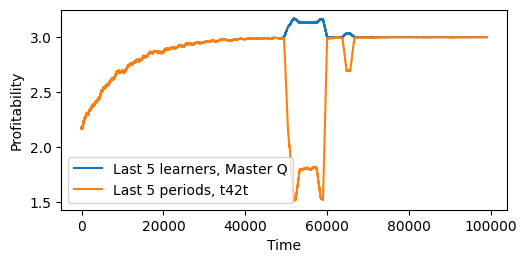

In [197]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 learners, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, t42t')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [187]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

In [171]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2 = many_games(options, 100000, 0.3, 0.0000922, 1000 ,0.95, final_Q)
final_Q2

run # 1 of  1000 runs
interval 6666.666666666667
run # 2 of  1000 runs
interval 6666.666666666667
run # 3 of  1000 runs
interval 6666.666666666667
run # 4 of  1000 runs
interval 6666.666666666667
run # 5 of  1000 runs
interval 6666.666666666667
run # 6 of  1000 runs
interval 6666.666666666667
run # 7 of  1000 runs
interval 6666.666666666667
run # 8 of  1000 runs
interval 6666.666666666667
run # 9 of  1000 runs
interval 6666.666666666667
run # 10 of  1000 runs
interval 6666.666666666667
run # 11 of  1000 runs
interval 6666.666666666667
run # 12 of  1000 runs
interval 6666.666666666667
run # 13 of  1000 runs
interval 6666.666666666667
run # 14 of  1000 runs
interval 6666.666666666667
run # 15 of  1000 runs
interval 6666.666666666667
run # 16 of  1000 runs
interval 6666.666666666667
run # 17 of  1000 runs
interval 6666.666666666667
run # 18 of  1000 runs
interval 6666.666666666667
run # 19 of  1000 runs
interval 6666.666666666667
run # 20 of  1000 runs
interval 6666.666666666667
run # 21 

array([[[38.50702003, 35.45604634],
        [40.93170941, 38.86650309]],

       [[31.88794196, 27.84162272],
        [36.06756467, 28.19916603]],

       [[30.2662092 , 23.87385795],
        [32.09175696, 26.22280155]],

       [[41.77727798, 42.11061353],
        [44.97985662, 34.65103886]],

       [[27.01284024, 21.70436573],
        [29.35404864, 22.40980788]],

       [[24.63542482, 18.77057503],
        [27.13673801, 20.00610126]],

       [[25.67642355, 18.94968896],
        [26.9753088 , 20.06256638]],

       [[27.84753125, 19.17252131],
        [28.13945496, 22.0059308 ]],

       [[36.34841738, 20.68978705],
        [39.55406882, 21.04950434]],

       [[45.16452556, 44.31335776],
        [45.94279045, 41.91749363]],

       [[45.60139716, 44.34200379],
        [45.97095176, 41.9426596 ]],

       [[45.5473643 , 44.31348765],
        [45.94292261, 41.94314552]],

       [[45.29092304, 44.31348765],
        [45.94292261, 41.94345227]],

       [[45.45798345, 44.31348765],
  

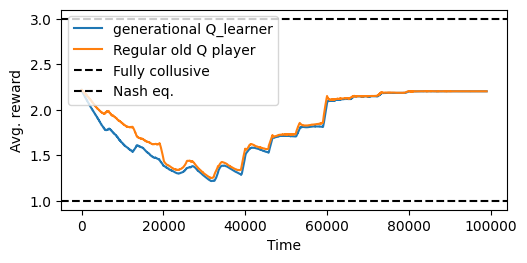

In [174]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular old Q player')
plt.axhline(y=3, color='k', linestyle = '--', label='Fully collusive')
plt.axhline(y=1, color='k', linestyle = '--', label='Nash eq.')
plt.xlabel("Time")
plt.ylabel("Avg. reward")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [122]:

Q = np.zeros((10,2,2))

all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(Q, options, 10000, 0.3, 0.000322, 0.95)



interval 666.6666666666666
Wrong dimensions
